<h1>Нахождение оптимального метода для поиска пластинок на фотографии<h1/>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def jup_cv2_show(*imgs, **kwargs):
    fig = plt.figure(figsize=(15,15))    
    
    rows = len(imgs)
    print("number of images = ", len(imgs))
    columns = 1
    
    for k, v in kwargs.items():
        if k == "columns":
            columns = v
        if k == "rows":
            if(v > len(imgs)):
                rows = v
    
    for i, img in enumerate(imgs):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(img)
            
def jupyter_imshow(imgs, columns=2):
    fig = plt.figure(figsize=(15,15))
    fig.tight_layout()

    if isinstance(imgs, list):
        number_of_files = len(imgs)
        rows = number_of_files//columns
        if (number_of_files%columns != 0):
            rows += 1
        
        for i, img in enumerate(imgs):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            fig.add_subplot(rows, columns, i+1)
            plt.axis("off")
            plt.imshow(img)
            
    elif isinstance(imgs, np.ndarray):
        imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)
        plt.axis("off")
        plt.imshow(imgs)

<h2>Обработка изображения<h2/>

<p>Оригинальное изображение<p/>

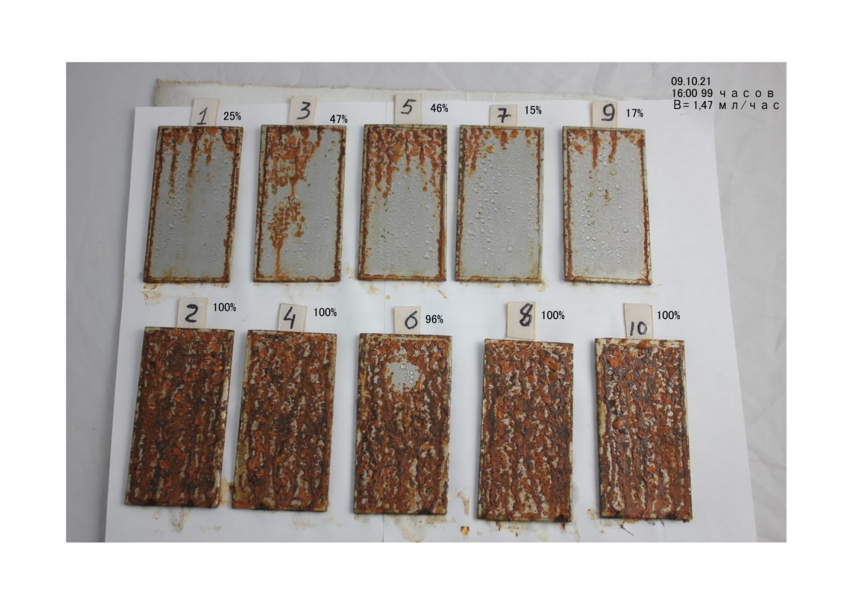

In [3]:
orig = cv2.imread('../metal_plates/image15.jpeg')
img = orig.copy()
jupyter_imshow(img)

<p>Поиск оптимального способа обработки изображения<p/>

In [4]:
def preprocess_image_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    canny=cv2.Canny(blurred, 120, 255, 1)
    return canny


def preprocess_image_adaptive(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1, 1), 500)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, 4)
    return thresh


def preprocess_image(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(3, 3), 50)
    #flag, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel)
    return thresh


def preprocess_image_kernel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1, 1), 500)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, 4)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel)
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, kernel)

    return thresh    

def refactor_card(self, bounding_box, width, height):
    bounding_box = cv2.UMat(np.array(bounding_box, dtype=np.float32))
    frame = [[449, 449], [0, 449], [0, 0], [449, 0]]
    if height > width:
        frame = [[0, 0],  [0, 449], [449, 449], [449, 0]]
    affine_frame = np.array(frame, np.float32)
    affine_transform = cv2.getPerspectiveTransform(bounding_box, affine_frame)
    refactored_card = cv2.warpPerspective(self.original_image, affine_transform, (450, 450))
    cropped_card = refactored_card[15:435, 15:435]
    return cropped_card

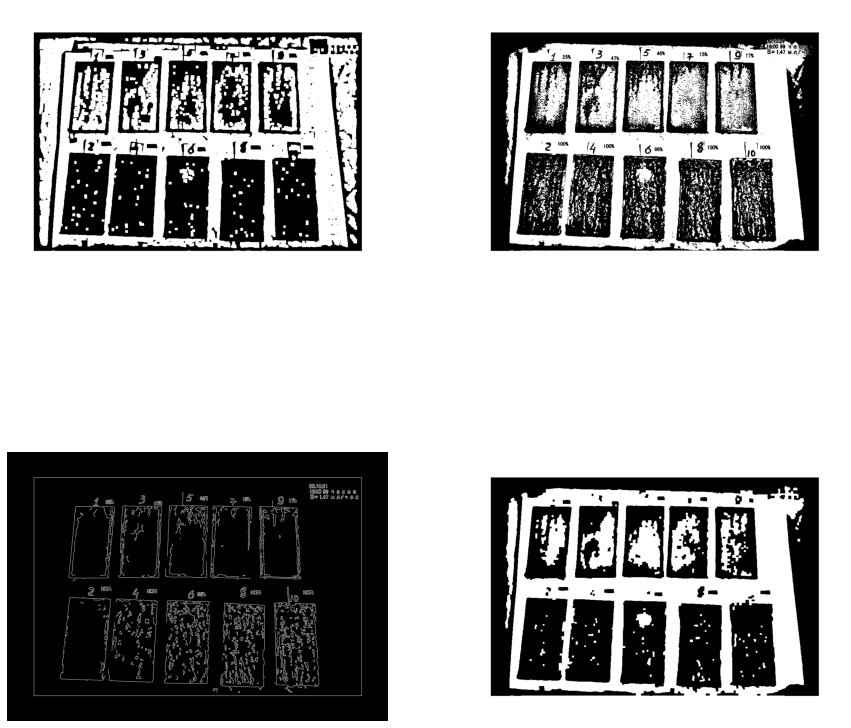

In [5]:
thresh_img = preprocess_image(img)
thresh_ad_img = preprocess_image_adaptive(img)
canny_img = preprocess_image_canny(img)
kernel_img = preprocess_image_kernel(img)

jupyter_imshow([thresh_img, thresh_ad_img, canny_img, kernel_img])

<p>Поиск оптимального способа нахождения контуров<p/>

In [6]:
def find_contours_1(orig_img, thresh_img):
    color = (0, 0, 255)
    thikness = 3
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

    raw_contours_img = orig_img.copy()
    rect_img = orig_img.copy()
        
    cv2.drawContours(raw_contours_img, contours, -1, (0,0,255), 3)

    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        color = (0, 0, 255)
        thickness = 2
        cv2.drawContours(rect_img, [box], 0, color, thikness)

    return raw_contours_img, rect_img


def find_contours_2(orig_img, thresh_img):
    #with adaptive
    raw_contours_img = orig_img.copy()
    rect_img = orig_img.copy()    

    color = (0, 0, 255)
    thikness = 3

    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30] 
    
    cv2.drawContours(raw_contours_img, contours, -1, color, thikness)

    for cnt in contours:
        peri = cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt, 0.05 * peri, True)
        if len(approx) == 4:
            cv2.drawContours(rect_img, [approx], 0, color, thikness)
            
    return raw_contours_img, rect_img

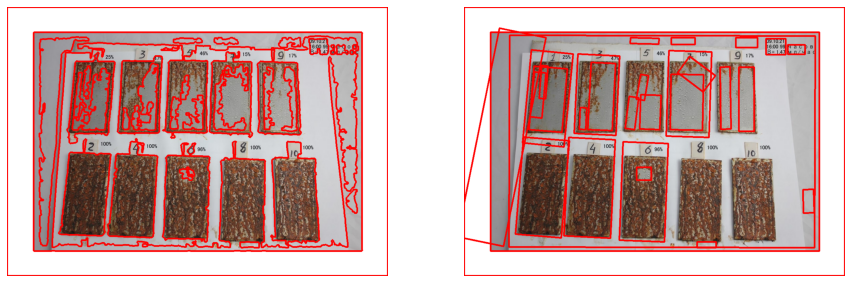

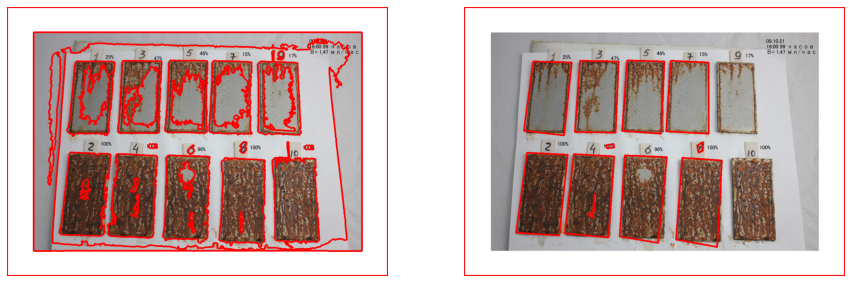

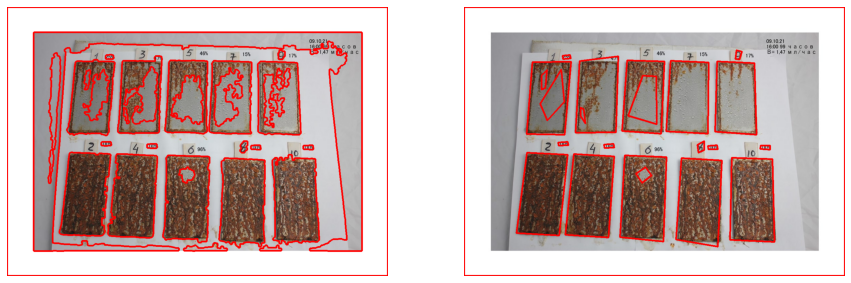

In [7]:
result1 = find_contours_1(img, thresh_img)
jupyter_imshow([result1[0], result1[1]])

result2 = find_contours_2(img, thresh_ad_img)
jupyter_imshow([result2[0], result2[1]])

# best one
result3 = find_contours_2(img, kernel_img)
jupyter_imshow([result3[0], result3[1]])

<p>Фильтрация контуров и его аппроксимация под прямоугольник <p/>

In [8]:
def find_area_approx(cnt):
    x,y,w,h = cv2.boundingRect(cnt)
    return w*h

def find_contours_best(orig_img, thresh_img):
    #with adaptive
    raw_contours_img = orig_img.copy()
    rect_img = orig_img.copy()    

    color = (0, 0, 255)
    thikness = 3

    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30] 
    
    cv2.drawContours(raw_contours_img, contours, -1, color, thikness)
    
    approx_list = []

    for cnt in contours:
        peri = cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt, 0.05 * peri, True)
        area = find_area_approx(approx)
        # add area filter by shape of plate and shape of table
        if len(approx) == 4 and area >= 20000 and area <= 180000:
            approx_list.append(approx)
            cv2.drawContours(rect_img, [approx], 0, color, thikness)
            
    return raw_contours_img, rect_img, approx_list

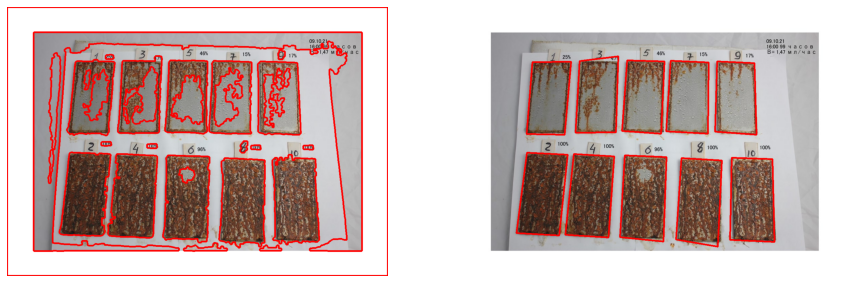

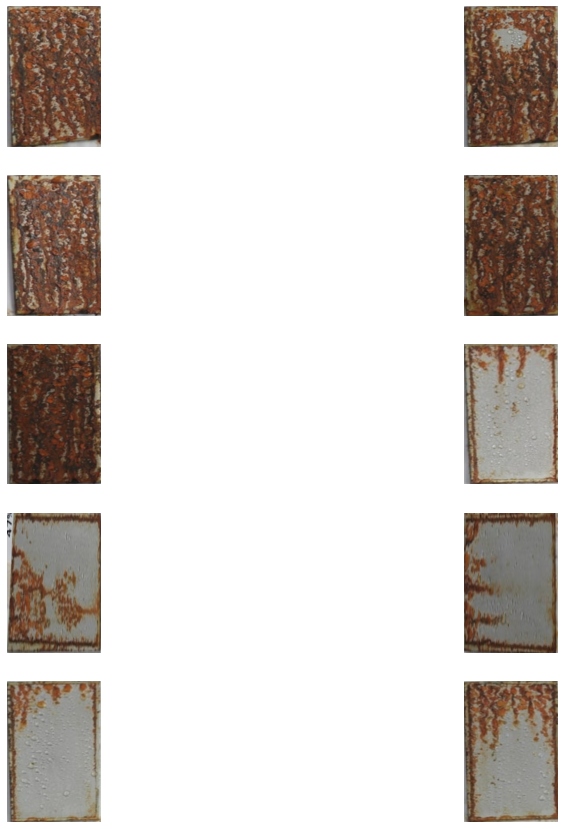

In [9]:
raw_contours, rect_img, approx_best = find_contours_best(img, kernel_img)
jupyter_imshow([raw_contours, rect_img])

wrap_orig = orig.copy()
wrap = [] #add range
h = np.array([ [0,0],[199,0],[199,299],[0,299] ],np.float32)

for i, approx in enumerate(approx_best):
    approx = approx.astype(np.float32)
    transform = cv2.getPerspectiveTransform(approx, h)
    wrapped_img = cv2.warpPerspective(wrap_orig,transform,(200,300))
    wrap.append(wrapped_img)

jupyter_imshow(wrap)

<p>Разбиваем пластинку на участки с помощью сетки<p/>

In [10]:
def show_grid(img, grid_size):
    grig_img = img.copy()
    height, width, channels = img.shape
    # draw gird
    for x in range(0, width-1, grid_size):
         cv2.line(grig_img, (x, 0), (x, height), (255, 0, 0), 1, 1)
    for y in range(0, height-1, grid_size):
         cv2.line(grig_img, (0, y), (height, y), (255, 0, 0), 1, 1)
            
    return grig_img

def crop_img(img, grid_size = 30):
    
    crops = []
    
    imgheight, imgwidth, channels = img.shape
    
    M = grid_size
    N = grid_size
    x1 = 0
    y1 = 0

    for y in range(0, imgheight, M):
        for x in range(0, imgwidth, N):
            if (imgheight - y) < M or (imgwidth - x) < N:
                break

            y1 = y + M
            x1 = x + N

            # check whether the patch width or height exceeds the image width or height
            if x1 >= imgwidth and y1 >= imgheight:
                x1 = imgwidth - 1
                y1 = imgheight - 1
                #Crop into patches of size MxN
                crops.append(img[y:y+M, x:x+N])
            elif y1 >= imgheight: # when patch height exceeds the image height
                y1 = imgheight - 1
                #Crop into patches of size MxN
                crops.append(img[y:y+M, x:x+N])
            elif x1 >= imgwidth: # when patch width exceeds the image width
                x1 = imgwidth - 1
                #Crop into patches of size MxN
                crops.append(img[y:y+M, x:x+N])
            else:
                #Crop into patches of size MxN
                crops.append(img[y:y+M, x:x+N])
                
    return crops

def find_grid_size(img):
    # size of wraped image will always same size
    w, h, _ = img.shape
    gcd_value = math.gcd(w, h)
    return int(gcd_value/4)

grid size =  25
columns =  8


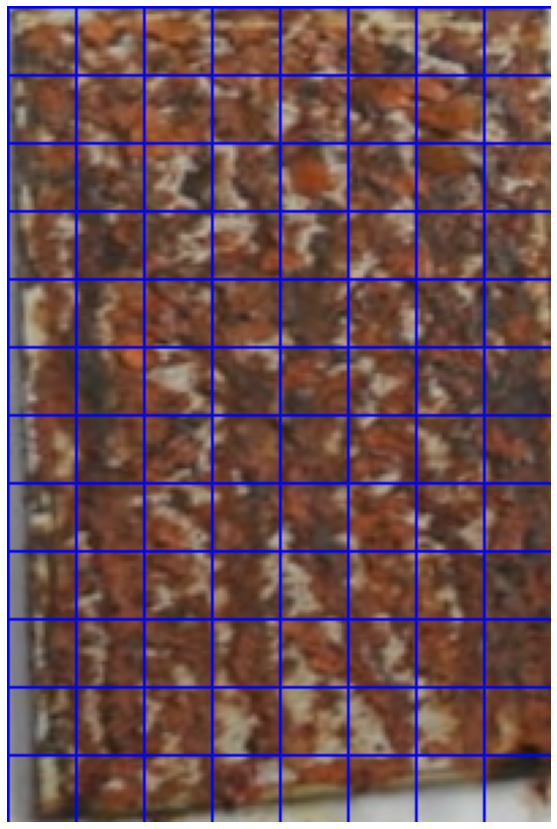

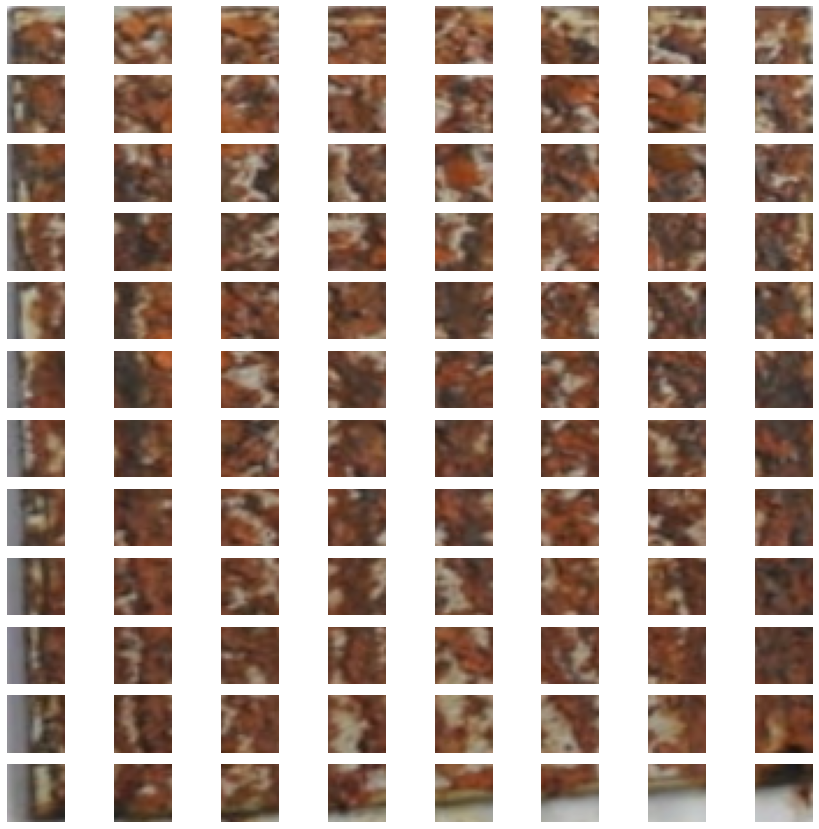

In [11]:
grid_size = find_grid_size(wrap[0])
columns = int(wrap[0].shape[1]/grid_size)
print("grid size = ", grid_size)
print("columns = ", columns)

grid_example = show_grid(wrap[0], grid_size)   
wrap_crops = crop_img(wrap[0], grid_size)


jupyter_imshow(grid_example, columns = 1)
jupyter_imshow(wrap_crops, columns = columns)